In [21]:
from scipy import stats
from sklearn.metrics import roc_curve, roc_auc_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML

from scipy.stats import ttest_ind
import warnings
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.stats import norm
import math
import seaborn as sns


warnings.filterwarnings('ignore')
%matplotlib inline

# color palette
palette1 = "#007BFF"
palette2 = "#3ABFC2"
palette3 = "#E1C081"
palette4 = "#E17A57"
palette5 = "#D92D3F"

# load processed results
df = pd.read_csv("data/results/results_processed.csv")
# creating dummy variables aka binary features
df["trivia"] = df.stimulation=="trivia"
df["true_statement"] = (df.ground_truth==True).astype(int)
df["explanation"] = (df.condition=="flag+explanation").astype(int)
df["text_explanation"] = "No Explanation"
df.loc[df.explanation==1,"text_explanation"] = "GPT Explanation"
df["deceptive_feedback"] = (df.explanation_type=="Deceptive").astype(int)


df["deceptive_feedback_x_explanation"] = df["deceptive_feedback"]*df["explanation"]
df["deceptive_feedback_x_true_statement"] = df["deceptive_feedback"]*df["true_statement"]
df["deceptive_feedback_x_ts_x_explanation"] = df["deceptive_feedback"]*df["explanation"]*df["true_statement"]
df["explanation_x_true_statement"] = df["explanation"]*df["true_statement"]

df["rating_delta"] = df.second_rating - df.initial_rating
df['z_rating_delta'] = (df.rating_delta - df.rating_delta.mean())/df.rating_delta.std()


In [22]:
df.head()

,PROLIFIC_PID,order,initial_rating,second_rating,knowledge,page_1_time,page_2_time,stimulus_ID,explanation_type,RecordedDate,...,true_statement,explanation,text_explanation,deceptive_feedback,deceptive_feedback_x_explanation,deceptive_feedback_x_true_statement,deceptive_feedback_x_ts_x_explanation,explanation_x_true_statement,rating_delta,z_rating_delta
0,6108e03508bd5499cf3c2a71,1,2.3,1.0,2.5,23.300,27.030,1022.0,Honest,2022-12-02 09:13:52,...,0,0,No Explanation,0,0,0,0,0,-1.3,-1.066436
1,5f78ce64cb5f144a98a4fa38,1,4.0,5.0,1.0,8.030,9.871,524.0,Honest,2022-12-02 09:15:10,...,1,0,No Explanation,0,0,0,0,0,1.0,0.860950
2,6046a861fd56950eb9e314ea,1,4.1,4.1,1.1,16.800,15.842,1038.0,Deceptive,2022-12-02 09:18:10,...,0,1,GPT Explanation,1,1,0,0,0,0.0,0.022956
3,5b66c8d4cda8590001dafb0c,1,2.0,4.5,2.0,12.168,14.103,1017.0,Deceptive,2022-12-02 09:18:53,...,0,1,GPT Explanation,1,1,0,0,0,2.5,2.117940
4,5f2c1cc33ea8e3068272d06c,1,1.0,1.0,2.1,5.601,14.100,1019.0,Deceptive,2022-12-02 09:20:48,...,0,1,GPT Explanation,1,1,0,0,0,0.0,0.022956


In [23]:
print("Initial Rating")
print(df.groupby("true_statement").initial_rating.mean())
print("Second Rating")
print(df.groupby("true_statement").second_rating.mean())
print(df.groupby(["trivia","true_statement","explanation","deceptive_feedback"])["PROLIFIC_PID"].nunique())

Initial Rating
true_statement
0    2.482965
1    3.218126
Name: initial_rating, dtype: float64
Second Rating
true_statement
0    2.566109
1    3.085328
Name: second_rating, dtype: float64
trivia  true_statement  explanation  deceptive_feedback
False   0               0            0                     288
                                     1                     288
                        1            0                     300
                                     1                     300
        1               0            0                     289
                                     1                     289
                        1            0                     300
                                     1                     300
True    0               0            0                     299
                                     1                     299
                        1            0                     311
                                     1                     311


In [24]:
x= []
for stimuli in [0,1]:
    for truth in [0,1]:
        for deception in [0,1]:
            #stats.ttest(X,Y)
            i = df[(df.trivia==stimuli) & (df.true_statement==truth) & (df.deceptive_feedback==deception)]
            res = sm.OLS(i["second_rating"], 
                                  sm.add_constant(i[[
    #                                   'deceptive_feedback',
                                      'explanation',
    #                                   "deceptive_feedback_x_explanation",
                                  ]]), 
                                  M=sm.robust.norms.HuberT()).fit(cov_type='cluster', cov_kwds={'groups': i['PROLIFIC_PID']})
            x.append(res)
stargazer = Stargazer([x[0],x[1],x[2],x[3],
                      x[4],x[5],x[6],x[7]])
stargazer.covariate_order([
                            'const',
                            'explanation',
                
                          ])
stargazer.custom_columns(['N – True (Honest)','N – True (Deceptive)',
                          'N – False (Honest)', 'N – False (Deceptive)',
                         'T – True (Honest)','T – True (Deceptive)',
                          'T – False (Honest)', 'T – False (Deceptive)'],
                         [1,1,1,1,1,1,1,1,])
stargazer.rename_covariates({
                            'const':'Constant',
                            'explanation':"GPT Explanation",
                            'deceptive_feedback': "Deceptive Feedback",
                            "deceptive_feedback_x_explanation": "Deceptive GPT Explanation",
                            })
stargazer.significant_digits(2)
stargazer.show_degrees_of_freedom(False)
stargazer.significance_levels([0.05, 0.01, 0.001])
stargazer.show_model_numbers(True)
HTML(stargazer.render_html())


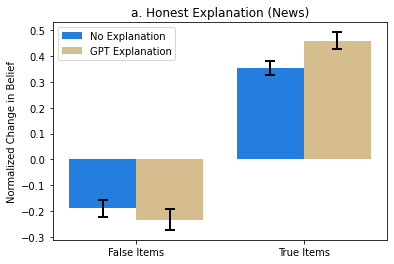

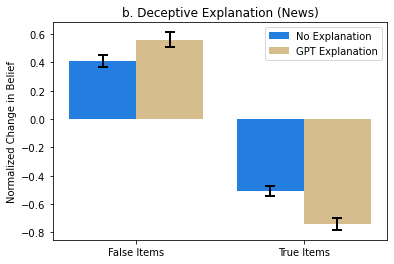

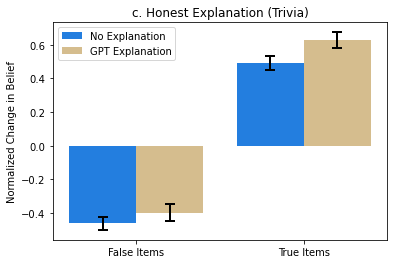

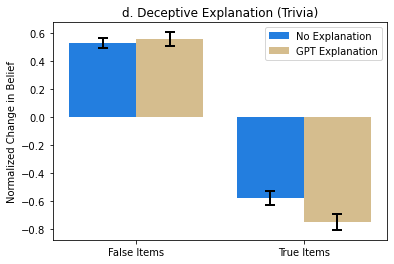

In [33]:
def plotter(data,name, hue):
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    colors = [palette1,palette3]
    custom = sns.set_palette(sns.color_palette(colors))
    ax = sns.barplot(x="true_statement", y="z_rating_delta",hue=hue,                    
                     hue_order=["No Explanation","GPT Explanation"],

                     data=data, 
                     alpha=.99,
                     errcolor="black", errwidth=2, capsize=.05,
#                      order=[ 'Atopic Dermatitis', 'CTCL', 'Dermatomyositis','Lichen Planus', 'Lyme',
#                             'Pityriasis Rosea', 
#            'Pityriasis Rubra Pilaris',  
#             'Secondary Syphilis',"Additional",],
                     palette=custom)
    ax.set_ylabel("Normalized Change in Belief")
    ax.set_xlabel("")
    ax.set_xticklabels(['False Items', 'True Items'])
    ax.legend()
#     ax.set_ylim(0,5)
    ax.set_title("{}".format(name))
#     fig.set_size_inches(15, 5)
    fig.savefig("f1_{}.png".format(name),dpi=600, bbox_inches="tight")



plotter(df[(df.trivia==0) & (df.deceptive_feedback==0)],"a. Honest Explanation (News)","text_explanation")
plotter(df[(df.trivia==0) & (df.deceptive_feedback==1)],"b. Deceptive Explanation (News)","text_explanation")
plotter(df[(df.trivia==1) & (df.deceptive_feedback==0)],"c. Honest Explanation (Trivia)","text_explanation")
plotter(df[(df.trivia==1) & (df.deceptive_feedback==1)],"d. Deceptive Explanation (Trivia)","text_explanation")

In [ ]:
print("extra")

In [ ]:
x = []
for stimuli in [0,1]:
    for dv in ["initial_rating","second_rating","rating_delta"]:
        i = df[df.trivia==stimuli]
        res = sm.OLS(i[dv], 
                      sm.add_constant(i[[
                          'true_statement',
                          'explanation',
                          "explanation_x_true_statement",
                          'deceptive_feedback',
                          'deceptive_feedback_x_true_statement',
                          "deceptive_feedback_x_explanation",
                          "deceptive_feedback_x_ts_x_explanation",
                          "CRT",
                      ]]), 
                      M=sm.robust.norms.HuberT()).fit(cov_type='cluster', cov_kwds={'groups': i['PROLIFIC_PID']})
        x.append(res)

stargazer = Stargazer([x[0],x[1],x[2],x[3],x[4],x[5]])
stargazer.covariate_order([
                            'const',
                            'true_statement',
                            'explanation',
                            "explanation_x_true_statement",
                            'deceptive_feedback',
                            'deceptive_feedback_x_true_statement',
                            "deceptive_feedback_x_explanation",
                            "deceptive_feedback_x_ts_x_explanation",
                            "CRT",
                          ])
stargazer.custom_columns(['N – 1st Rating', 'N – 2nd Rating',"N – Rating Delta",
                         'T – 1st Rating', 'T – 2nd Rating',"T – Rating Delta"],
                         [1,1,1,1,1,1])
stargazer.rename_covariates({
                            'const':'Constant',
                            'true_statement': "True Statement",
                            'explanation':"GPT Explanation",
                            "explanation_x_true_statement": "GPT Explanation * False Statement",
                            'deceptive_feedback': "Deceptive Feedback",
                            'deceptive_feedback_x_true_statement': "Deceptive Feedback * False Statement",
                            "deceptive_feedback_x_explanation": "Deceptive GPT Explanation",
                            "deceptive_feedback_x_ts_x_explanation": "Deceptive GPT Explanation * False Statement",
                            })
stargazer.significant_digits(2)
stargazer.show_degrees_of_freedom(False)
stargazer.significance_levels([0.05, 0.01, 0.001])
stargazer.show_model_numbers(True)
stargazer.add_line('Number of Participants', [
    df[df.trivia==0].PROLIFIC_PID.nunique(),
    df[df.trivia==0].PROLIFIC_PID.nunique(),
    df[df.trivia==0].PROLIFIC_PID.nunique(),
    df[df.trivia==1].PROLIFIC_PID.nunique(),
    df[df.trivia==1].PROLIFIC_PID.nunique(),
    df[df.trivia==1].PROLIFIC_PID.nunique(),
    ])
stargazer.add_line('Number of Stimuli', [
    df[df.trivia==0].topic.nunique(),
    df[df.trivia==0].topic.nunique(),
    df[df.trivia==0].topic.nunique(),
    df[df.trivia==1].topic.nunique(),
    df[df.trivia==1].topic.nunique(),
    df[df.trivia==1].topic.nunique(),
    ])
HTML(stargazer.render_html())


In [ ]:
df.columns

In [ ]:
# double checking that the dta looks balanced, all good
bb = df.groupby(["trivia","true_statement","explanation","deceptive_feedback","stimulus_ID"]).initial_rating.mean().reset_index()
aa = df.groupby(["trivia","true_statement","explanation","deceptive_feedback","stimulus_ID"]).second_rating.mean().reset_index()
aa

In [ ]:
# Visual showing feedback (1) influences updating (2) people believe fake news/trivia less when given honest explanation and people believe fake news/trivia more when given deceptive explanation

plt.plot([1,2,3,4,5],[1,2,3,4,5])
plt.scatter(bb[(bb.true_statement==1) & (bb.explanation==1) & (bb.deceptive_feedback==0)]["initial_rating"],
            bb[(bb.true_statement==1) & (bb.explanation==1) & (bb.deceptive_feedback==1)]["initial_rating"])
plt.xlabel("Belief in True Statement with Honest Feedback")
plt.ylabel("Belief in True Statement with Deceptive Feedback")
plt.title("Before Feedback")
plt.show()
plt.plot([1,2,3,4,5],[1,2,3,4,5])
plt.scatter(aa[(aa.true_statement==1) & (aa.explanation==1) & (aa.deceptive_feedback==0)]["second_rating"],
            aa[(aa.true_statement==1) & (aa.explanation==1) & (aa.deceptive_feedback==1)]["second_rating"])
plt.xlabel("Belief in True Statement with Honest Feedback")
plt.ylabel("Belief in True Statement with Deceptive Feedback")
plt.title("After Feedback")
plt.show()